# Spin-polarised-current-driven domain wall

**Author**: Marijan Beg, Weiwei Wang

**Date**: 18 Mar 2016

This notebook can be downloaded from the github repository, found [here](https://github.com/computationalmodelling/fidimag/blob/master/doc/ipynb/current-driven-domain-wall.ipynb).

### Problem specification

The simulated sample is a 1D nanowire cuboid with $L=1000 \,\text{nm}$ length with finite difference discretisation $d_{x} = d_{y} = d_{z} = 2 \,\text{nm}$.

The material parameters (similar to permalloy) are:
    
- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8.6 \times 10^{5} \,\text{A/m}$,
- uniaxial anisotropy constant $K=5 \times 10^{4} \,\text{J/m}^{3}$ with $(0, 0, 1)$ easy-axis,
- Gilbert damping $\alpha = 0.5$.

After the system is relaxed to a domain wall, a spin-polarised current with $J=1 \times 10^{12} \text{A/m}^{2}$ density is applied in the positive x direction $(1, 0, 0)$.

### Simulation functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fidimag.micro import Sim, UniformExchange, UniaxialAnisotropy
from fidimag.common import CuboidMesh
%matplotlib inline

We start by defining parameters and a function for initialising the system so that it relaxes to the domain wall.

In [2]:
Ms = 8.6e5  # magnetisation saturation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
alpha = 0.5  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ration (m/As)
K = 5e4  # uniaxial anisotropy constant (J/m**3)
J = 1e12  # spin-polarised current density (A/m**2)
beta = 1  # STT parameter

def init_m(pos):
    x = pos[0]

    if x < 200:
        return (1, 0, 0)
    elif 200 <= x < 300:
        return (0, 1, 1)
    else:
        return (-1, 0, 0)

Using this function, we create a new function which relaxes the system to its equilibrium (domain wall) state according to the problem specification.

In [3]:
def relax_system(mesh):
    # Create a simulation object.
    sim = Sim(mesh)

    # Set simulation parameters.
    sim.driver.set_tols(rtol=1e-8, atol=1e-8)
    sim.driver.alpha = alpha
    sim.driver.gamma = gamma
    sim.Ms = Ms

    # Add energies to the system.
    sim.add(UniformExchange(A=A))
    sim.add(UniaxialAnisotropy(K))

    # Initialise the system.
    sim.set_m(init_m)
    
    # Relax the system and save the state in m0.npy
    sim.driver.relax(dt=1e-14, stopping_dmdt=0.01, max_steps=5000,
                     save_m_steps=None, save_vtk_steps=None)

    np.save('m0.npy', sim.spin)

A plot of the system's magnetisation can be created using the following convenience function.

In [4]:
def plot_magnetisation(components):
    plt.figure(figsize=(8, 6))

    comp = {'mx': 0, 'my': 1, 'mz': 2}

    for element in components:
        data = np.load(element[0])
        data.shape = (-1, 3)

        mc = data[:, comp[element[1]]]
        
        # The label is the component and the file name
        plt.plot(mc, label=element[1])

    plt.legend()
    plt.xlabel('x (nm)')
    plt.ylabel('mx, my')
    plt.grid()
    plt.ylim([-1.05, 1.05])

Finally, we create a function for driving a domain wall using the spin-polarised current. All *npy* and *vtk* files are saved in the **\{simulation_name\}_npys** and **\{simulation_name\}_vtks** folders, respectively.

In [5]:
def excite_system(mesh, time, snapshots):
    # Specify the stt dynamics in the simulation
    sim = Sim(mesh, name='dyn', driver='llg_stt')
    
    # Set the simulation parameters
    sim.driver.set_tols(rtol=1e-12, atol=1e-14)
    sim.driver.alpha = alpha
    sim.driver.gamma = gamma
    sim.Ms = Ms

    # Add energies to the system.
    sim.add(UniformExchange(A=A))
    sim.add(UniaxialAnisotropy(K))

    # Load the initial state from the npy file saved in the realxation stage.
    sim.set_m(np.load('m0.npy'))

    # Set the spin-polarised current in the x direction.
    sim.driver.jx = J
    sim.driver.beta = beta

    # The simulation will run for x ns and save
    # 'snaps' snapshots of the system in the process
    ts = np.linspace(0, time, snapshots)

    for t in ts:
        sim.driver.run_until(t)
        sim.save_vtk()
        sim.save_m()


### Simulation

Before we run a simulation using previously defined functions, a finite difference mesh must be created.

In [6]:
L = 2000  # nm
dx = dy = dz = 2  # nm

mesh = CuboidMesh(nx=int(L/dx), ny=1, nz=1, dx=dx, dy=dy, dz=dz, unit_length=1e-9)

Now, the system is relaxed and the domain wall equilibrium state is obtained, saved, and later used in the next stage.

In [7]:
%%capture
relax_system(mesh);

Plot the magnetisation components of the relaxed state.

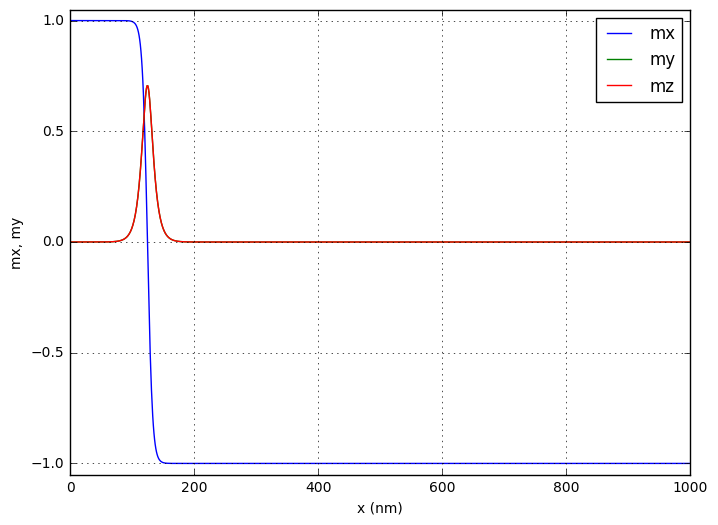

In [8]:
plot_magnetisation([['m0.npy', 'mx'], ['m0.npy', 'my'], ['m0.npy', 'mz']])

The DW is at the maximum value of $|m_z|$ or $|m_y|$. Consequently, the domain wall position is:

In [9]:
m0_z = np.load('m0.npy').reshape(-1, 3)[:, 2]
x = np.arange(len(m0_z))
index_max = np.argmax(np.abs(m0_z))

print('Maximum |m_z| at x = %s' % x[index_max])

Maximum |m_z| at x = 124


Using the obtained domain wall equilibrium state, we now simulate its motion in presence of a spin-polarised current.

In [10]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
excite_system(mesh, 1.5e-9, 151);

We plot once again to compare the initial state with the ones after a SP current was applied.

(0, 200)

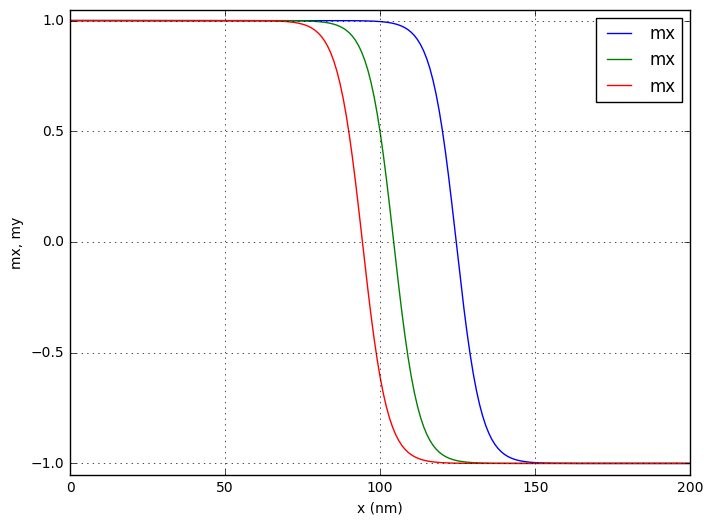

In [11]:
# We can plot the m_x component for a number snapshots
# to observe the DW motion
# We will plot the 100th and 150th files (we can also compute
# until the system reaches ~5 ns to improve the effect)
plot_magnetisation([['m0.npy', 'mx'],
                    ['dyn_npys/m_100.npy', 'mx'],
                    ['dyn_npys/m_150.npy', 'mx']])
plt.xlim([0, 200])